Cible voiture à 45° - Gain: -18.61 dB - Distance: 49.999998927116394m


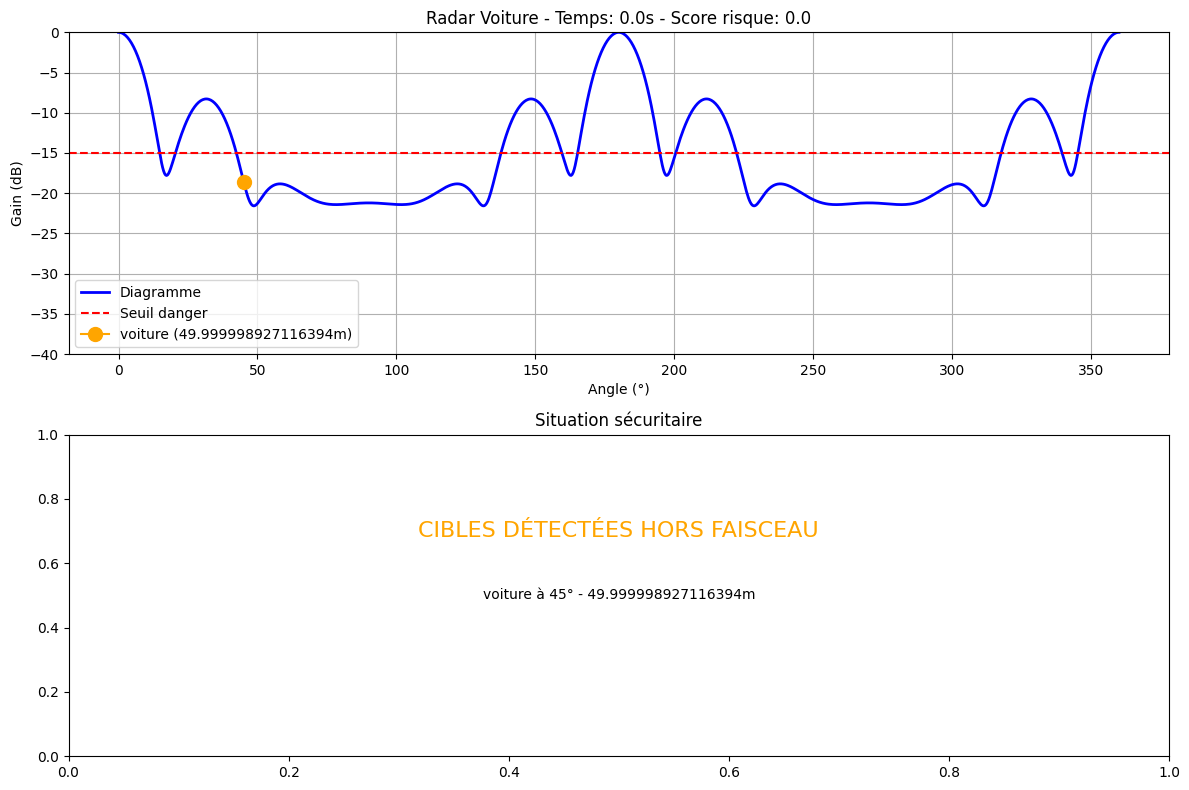

Cible voiture à 45° - Gain: -17.77 dB - Distance: 48.16061294078827m


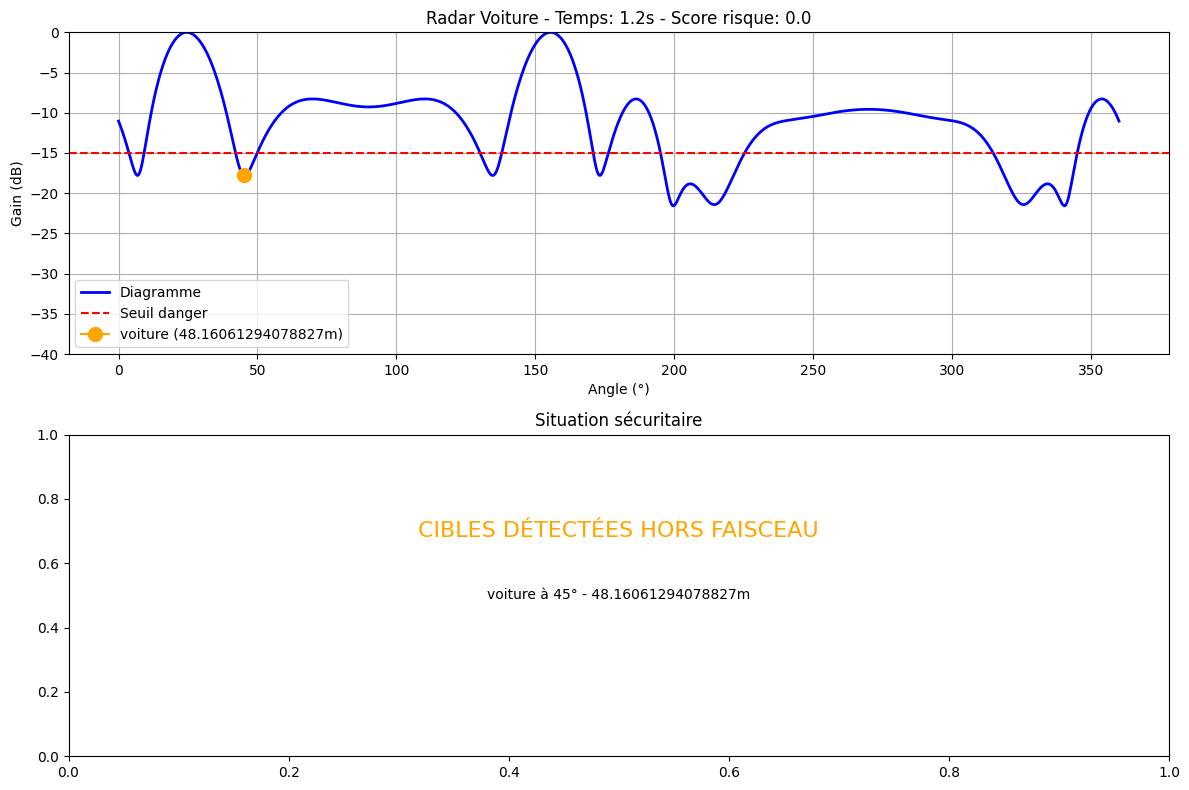

Cible voiture à 45° - Gain: -0.00 dB - Distance: 46.63583862781525m


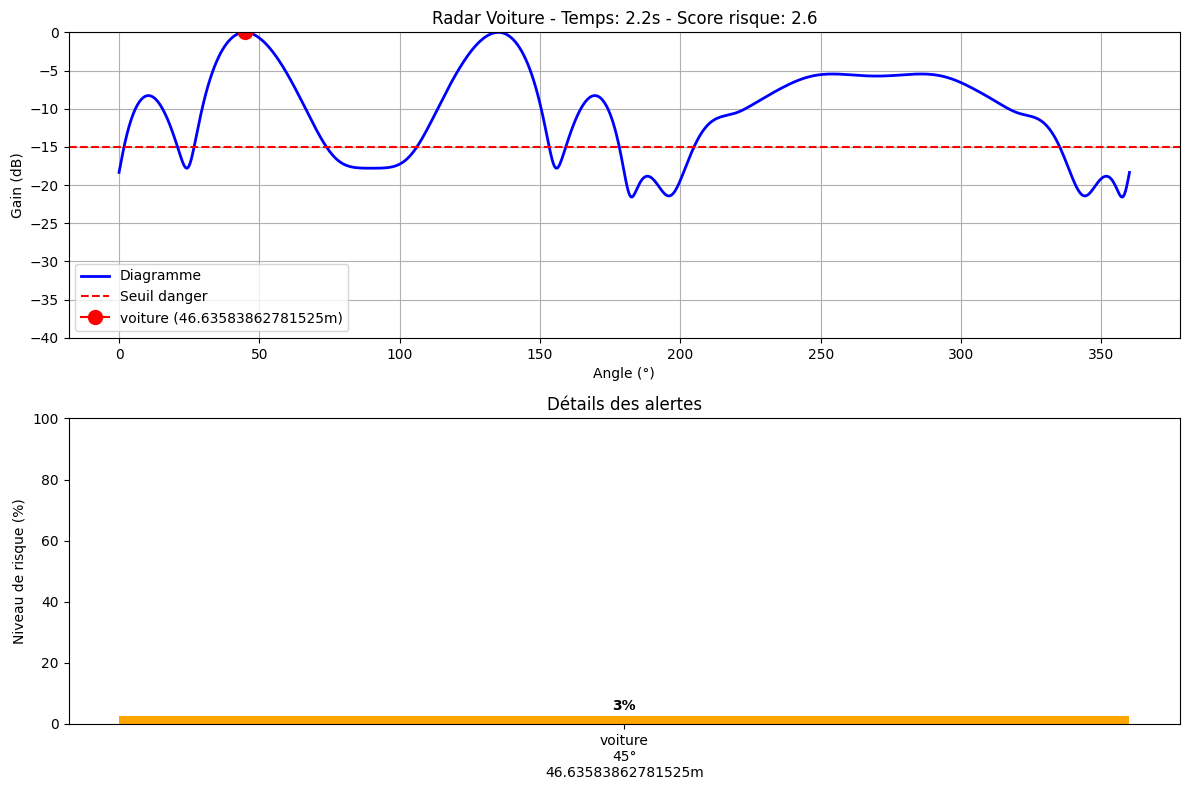

Cible voiture à 45° - Gain: -7.93 dB - Distance: 45.207603454589844m


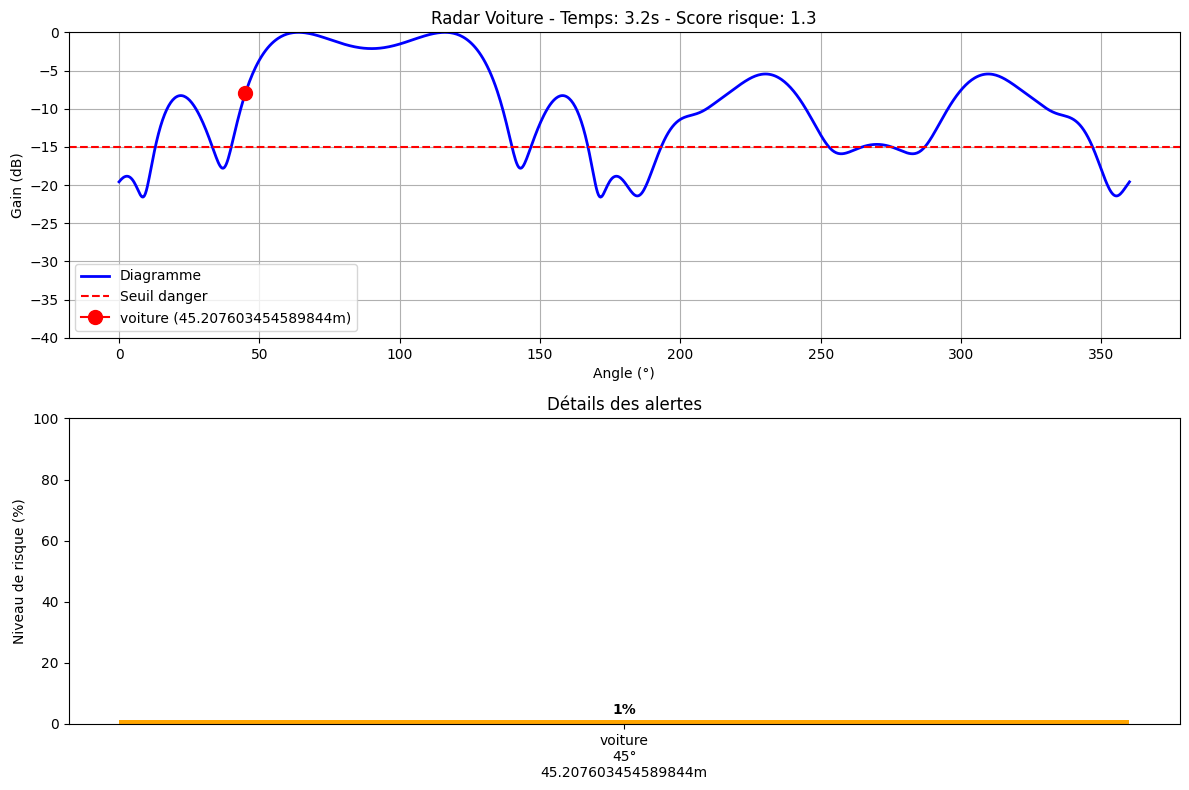

Cible voiture à 45° - Gain: -17.38 dB - Distance: 43.88014602661133m


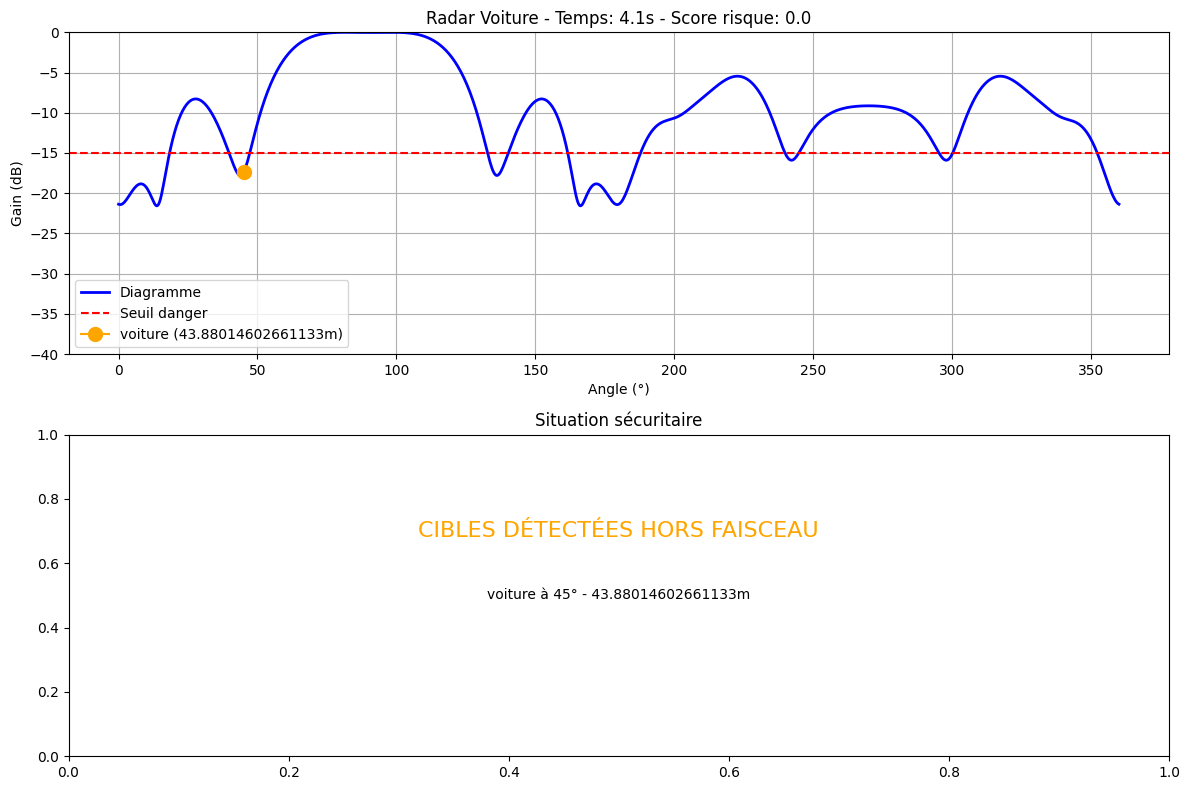

Cible voiture à 45° - Gain: -15.11 dB - Distance: 42.09344255924225m


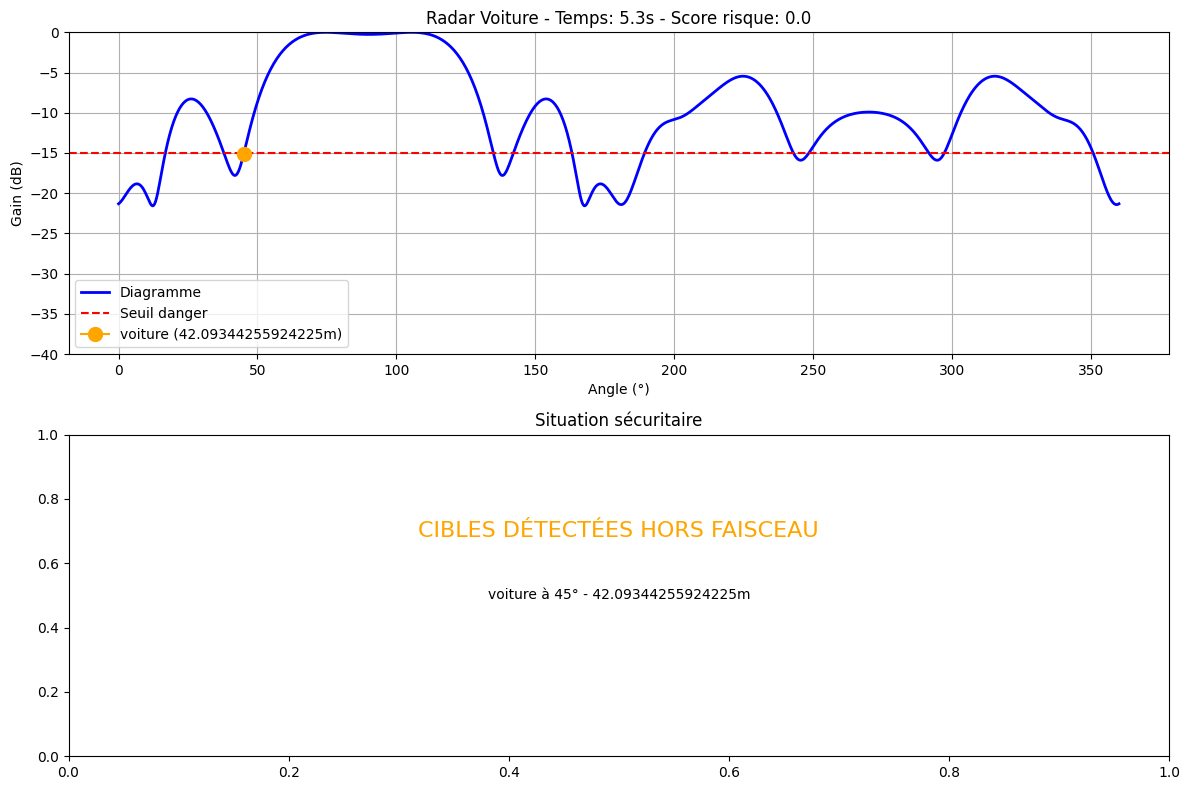

Cible voiture à 45° - Gain: -2.80 dB - Distance: 40.66224157810211m


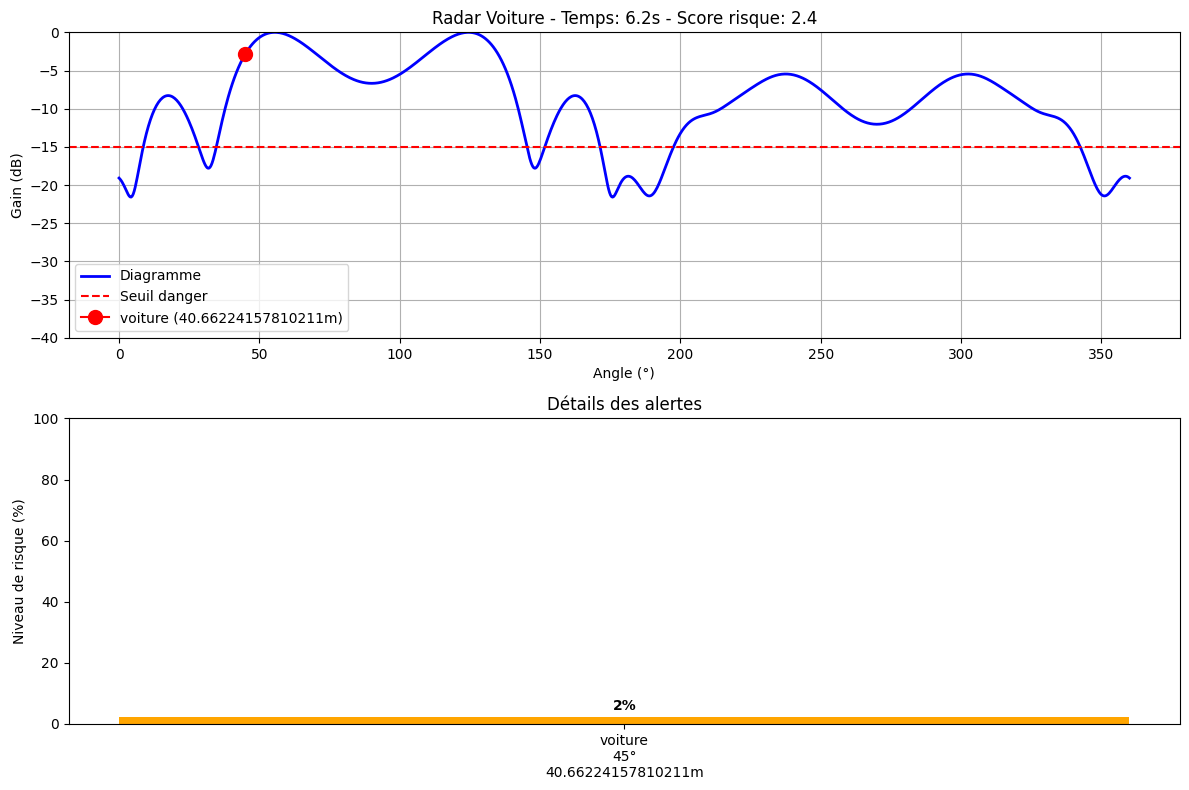

Simulation terminée


In [11]:
'''
Le code simule un système de détection pour voiture utilisant un réseau d'antennes. Il modélise
la capacité du système à détecter des objets dans différentes directions via un diagramme de
rayonnement pointé à 45°. Des cibles simulées (voitures, piétons) sont analysées : si elles se
trouvent dans les zones sensibles du diagramme (gain élevé), un score de risque est calculé basé
sur leur distance, type et position angulaire. Le système génère des alertes temps réel pour le
conducteur.
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time

class RadarVoiture:

    def __init__(self):
        # === Paramètres radar ===
        self.carrierFreq = 2.45e9
        self.c = 3e8
        self.lambda_ = self.c / self.carrierFreq
        self.k = 2 * np.pi / self.lambda_

        # === Réseau d'antennes ===
        self.rings = 5
        self.radii = np.linspace(0.2 * self.lambda_, 2.2 * self.lambda_, self.rings)
        self.elements_per_ring = [2, 4, 4, 5, 5]

        # === Mémoire des détections ===
        self.histoire_detections = []
        self.seuil_danger = -15  # dB
        self.score_risque = 0

    def calculer_diagramme(self, theta0deg):
        """Calcule le diagramme de rayonnement pour une direction donnée"""
        theta0 = np.deg2rad(theta0deg)
        phi0 = 0
        theta = np.linspace(0, 2 * np.pi, 1000)
        phi = 0
        AF_az = np.zeros_like(theta, dtype=complex)

        for ring in range(self.rings):
            a = self.radii[ring]
            N = self.elements_per_ring[ring]
            if N == 0:
                continue
            phi_n = 2 * np.pi * np.arange(N) / N
            for n in range(N):
                phase = self.k * a * (np.sin(theta) * np.cos(phi - phi_n[n]) -
                                    np.sin(theta0) * np.cos(phi0 - phi_n[n]))
                AF_az += np.exp(1j * phase)

        AF_norm_az = np.abs(AF_az) / np.max(np.abs(AF_az))
        AF_dB_az = 20 * np.log10(AF_norm_az + np.finfo(float).eps)
        return theta, AF_dB_az

    def simuler_environnement(self, temps):
        """Simule des cibles (véhicules, piétons) dans l'environnement"""
        # Exemple de cibles simulées
        cibles = []

        # Véhicule devant à 50m, angle 45°
        if temps < 30:  # Apparait pendant 30 secondes
            cibles.append({'angle': 45, 'distance': 50 - temps*1.5, 'type': 'voiture'})

        # Piéton sur le côté à 20m, angle 80°
        if 10 < temps < 40:
            cibles.append({'angle': 80, 'distance': 20, 'type': 'piéton'})

        return cibles

    def analyser_risque(self, cibles, diagramme_dB):
        """Analyse le risque et calcule un score"""
        risque_total = 0
        alertes = []

        for cible in cibles:
            # Trouve l'angle le plus proche dans le diagramme
            theta_deg = np.linspace(0, 360, len(diagramme_dB))
            idx_angle = np.argmin(np.abs(theta_deg - cible['angle']))
            gain_cible = diagramme_dB[idx_angle]

            # Calcul du risque
            if gain_cible > self.seuil_danger:
                risque = (gain_cible - self.seuil_danger) / (0 - self.seuil_danger)
                risque *= (100 / cible['distance'])  # Pondération par distance

                if cible['type'] == 'piéton':
                    risque *= 1.5  # Risque accru pour piétons

                risque_total += risque
                alertes.append({
                    'type': cible['type'],
                    'angle': cible['angle'],
                    'distance': cible['distance'],
                    'risque': min(risque, 100)
                })

        return risque_total, alertes

    def afficher_interface_conducteur(self, temps, risque, alertes):
        """Affiche une interface simplifiée pour le conducteur"""
        plt.figure(figsize=(10, 6))

        # Diagramme de rayonnement
        plt.subplot(2, 1, 1)
        theta_deg = np.linspace(0, 360, 1000)
        theta, diagramme = self.calculer_diagramme(45)
        plt.plot(theta_deg, diagramme)
        plt.axhline(y=self.seuil_danger, color='r', linestyle='--', label='Seuil danger')
        plt.title(f"Radar Voiture - Temps: {temps:.1f}s - Score risque: {risque:.1f}")
        plt.ylabel("Gain (dB)")
        plt.ylim([-40, 0])
        plt.grid(True)

        # Alertes
        plt.subplot(2, 1, 2)
        if alertes:
            types = [alerte['type'] for alerte in alertes]
            risques = [alerte['risque'] for alerte in alertes]
            angles = [alerte['angle'] for alerte in alertes]

            bars = plt.bar(range(len(alertes)), risques, color='red', alpha=0.7)
            plt.xticks(range(len(alertes)), [f"{t}\n{ang}°" for t, ang in zip(types, angles)])
            plt.ylabel("Niveau de risque")
            plt.ylim([0, 100])
            plt.title("Alertes actives")

            # Ajouter des valeurs sur les barres
            for bar, risque_val in zip(bars, risques):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                        f"{risque_val:.0f}%", ha='center')
        else:
            plt.text(0.5, 0.5, "AUCUNE ALERTE", ha='center', va='center',
                    transform=plt.gca().transAxes, fontsize=20, color='green')
            plt.title("Situation sécuritaire")

        plt.tight_layout()
        plt.pause(0.1)
        plt.clf()

    def analyser_risque_corrige(self, cibles, diagramme_dB):
        """Version corrigée - Prend en compte les cibles réelles"""
        risque_total = 0
        alertes = []

        theta_deg = np.linspace(0, 360, len(diagramme_dB))

        for cible in cibles:
            # Trouve l'angle le plus proche dans le diagramme
            idx_angle = np.argmin(np.abs(theta_deg - cible['angle']))
            gain_cible = diagramme_dB[idx_angle]

            print(f"Cible {cible['type']} à {cible['angle']}° - Gain: {gain_cible:.2f} dB - Distance: {cible['distance']}m")

            # Vérifie si la cible est dans une zone de bon gain
            if gain_cible > self.seuil_danger:
                # Calcul du risque BASÉ SUR LA CIBLE RÉELLE
                risque = (gain_cible - self.seuil_danger) / (0 - self.seuil_danger)
                risque *= (100 / max(1, cible['distance']))  # Pondération distance

                if cible['type'] == 'piéton':
                    risque *= 1.5  # Risque accru pour piétons
                elif cible['type'] == 'voiture':
                    risque *= 1.2  # Risque moyen pour voiture

                risque = min(risque, 100)  # Limite à 100%
                risque_total += risque

                alertes.append({
                    'type': cible['type'],
                    'angle': cible['angle'],
                    'distance': cible['distance'],
                    'risque': risque,
                    'gain': gain_cible
                })

        return risque_total, alertes

    def afficher_interface_corrigee(self, temps, risque, alertes, cibles, diagramme):
        """Interface montrant VRAIMENT ce qui se passe"""
        plt.figure(figsize=(12, 8))

        # Diagramme avec marquage des cibles
        plt.subplot(2, 1, 1)
        theta_deg = np.linspace(0, 360, len(diagramme))
        plt.plot(theta_deg, diagramme, 'b-', linewidth=2, label='Diagramme')
        plt.axhline(y=self.seuil_danger, color='r', linestyle='--', label='Seuil danger')

        # Marquage des cibles sur le diagramme
        for cible in cibles:
            idx = np.argmin(np.abs(theta_deg - cible['angle']))
            gain_cible = diagramme[idx]
            couleur = 'red' if gain_cible > self.seuil_danger else 'orange'
            marqueur = 'o' if cible['type'] == 'voiture' else 's'
            plt.plot(cible['angle'], gain_cible, color=couleur, marker=marqueur,
                    markersize=10, label=f"{cible['type']} ({cible['distance']}m)")

        plt.title(f"Radar Voiture - Temps: {temps:.1f}s - Score risque: {risque:.1f}")
        plt.ylabel("Gain (dB)")
        plt.xlabel("Angle (°)")
        plt.ylim([-40, 0])
        plt.grid(True)
        plt.legend()

        # Alertes détaillées
        plt.subplot(2, 1, 2)
        if alertes:
            types = [f"{a['type']}\n{a['angle']}°\n{a['distance']}m" for a in alertes]
            risques = [a['risque'] for a in alertes]

            bars = plt.bar(types, risques, color=['red' if r > 50 else 'orange' for r in risques])
            plt.ylabel("Niveau de risque (%)")
            plt.ylim([0, 100])
            plt.title("Détails des alertes")

            for bar, risque_val in zip(bars, risques):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                        f"{risque_val:.0f}%", ha='center', fontweight='bold')
        else:
            if cibles:
                # Il y a des cibles mais pas d'alertes (hors du faisceau)
                plt.text(0.5, 0.7, "CIBLES DÉTECTÉES HORS FAISCEAU",
                        ha='center', va='center', transform=plt.gca().transAxes,
                        fontsize=16, color='orange')
                for i, cible in enumerate(cibles):
                    plt.text(0.5, 0.5 - i*0.1, f"{cible['type']} à {cible['angle']}° - {cible['distance']}m",
                            ha='center', va='center', transform=plt.gca().transAxes)
            else:
                plt.text(0.5, 0.5, "AUCUNE CIBLE DÉTECTÉE",
                        ha='center', va='center', transform=plt.gca().transAxes,
                        fontsize=20, color='green')
            plt.title("Situation sécuritaire")

        plt.tight_layout()
        plt.pause(0.1)

# === SIMULATION TEMPS RÉEL ===
# === SIMULATION TEMPS RÉEL ===
def simulation_radar_voiture():
    radar = RadarVoiture()
    temps_debut = time.time()

    try:
        while True:
            temps_ecoule = time.time() - temps_debut

            # 1. Simulation de l'environnement
            cibles = radar.simuler_environnement(temps_ecoule)

            #variable pour que le diagramme varie en fonction du temps
            # faisceau qui scanne 0-->360°
            angle_pointage = (temps_ecoule * 20) % 360  # rotation à 20°/s


            # 2. Calcul du diagramme de rayonnement
            theta, diagramme = radar.calculer_diagramme(angle_pointage)

            # 3. Analyse des risques
            score_risque, alertes = radar.analyser_risque_corrige(cibles, diagramme)

            # 4. Affichage
            radar.afficher_interface_corrigee(
                temps_ecoule,
                score_risque,
                alertes,
                cibles,
                diagramme
            )

            # 5. Alertes sonores
            if score_risque > 50:
                print("🚨 ALERTE: Risque élevé détecté!")
            elif score_risque > 20:
                print("⚠️  Attention: Risque modéré")

            time.sleep(0.5)

    except KeyboardInterrupt:
        print("Simulation terminée")

# === LANCEMENT ===
if __name__ == "__main__":
    simulation_radar_voiture()